# FACEBOOK

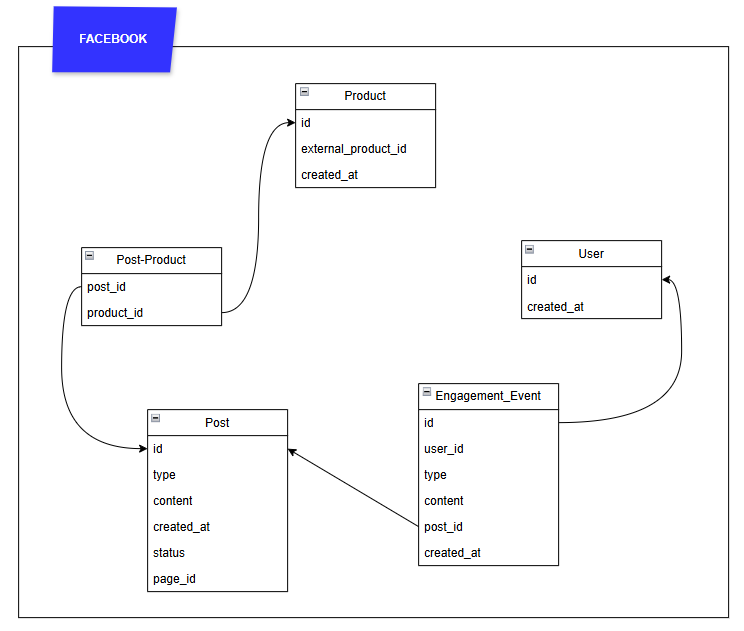

In [274]:
import datetime
import os
import pandas as pd
from dotenv import load_dotenv
import requests
import json
import random

random.seed(42)

# Prepare variables
load_dotenv()
ACCESS_TOKEN = os.getenv("FB_PAGE_1_TOKEN")
base_url = "https://graph.facebook.com/v23.0/"

# ========================
# ======= PRODUCTS =======
# ========================
def get_products():
    products_df = pd.read_csv('../POS/products.csv')

    products_df = products_df[['id']]
    products_df["created_time"] = products_df["id"].apply(lambda x: datetime.datetime.now())

    products_df.to_csv('products.csv', index=False)


# ========================
# ======== POSTS =========
# ========================
def get_page_info(ACCESS_TOKEN, base_url):
    params = {
        "access_token": ACCESS_TOKEN
    }

    response = requests.get(f"{base_url}/me", params=params)

    return response.json()


def get_posts():
    # Get page id
    page_id = get_page_info(ACCESS_TOKEN, base_url)["id"]

    # Get posts data
    params = {
        "access_token": ACCESS_TOKEN,
        "fields": """id,message,created_time, attachments{media_type}, comments.summary(true), shares, 
            reactions.type(LIKE).summary(true).as(like), 
            reactions.type(LOVE).summary(true).as(love),
            reactions.type(WOW).summary(true).as(wow),
            reactions.type(HAHA).summary(true).as(haha),
            reactions.type(SAD).summary(true).as(sad),
            reactions.type(ANGRY).summary(true).as(angry)"""
    }

    response = requests.get(f"{base_url}/{page_id}/feed", params=params)
    posts_data = response.json()["data"]

    posts_df = pd.DataFrame(posts_data)
    posts_df["type"] = posts_df["attachments"].map(lambda x: x["data"][0]["media_type"] if isinstance(x, dict) and x.get("data") else "text")
    
    posts_df["total_comments"] = posts_df["comments"].map(lambda x: x["summary"]["total_count"] if isinstance(x, dict) and x.get("data") else 0)

    posts_df["total_shares"] = posts_df["shares"].map(lambda x: x["count"] if isinstance(x, dict) else 0)

    posts_df['total_likes'] = posts_df['like'].map(lambda x: x['summary']['total_count'] if isinstance(x, dict) else 0)
    posts_df['total_loves'] = posts_df['love'].map(lambda x: x['summary']['total_count'] if isinstance(x, dict) else 0)
    posts_df['total_wows'] = posts_df['wow'].map(lambda x: x['summary']['total_count'] if isinstance(x, dict) else 0)
    posts_df['total_hahas'] = posts_df['haha'].map(lambda x: x['summary']['total_count'] if isinstance(x, dict) else 0)
    posts_df['total_sads'] = posts_df['sad'].map(lambda x: x['summary']['total_count'] if isinstance(x, dict) else 0)
    posts_df['total_angrys'] = posts_df['angry'].map(lambda x: x['summary']['total_count'] if isinstance(x, dict) else 0)

    posts_df["page_id"] = page_id

    posts_df = posts_df.drop(columns=["attachments", "comments", "shares", "like", "love", "wow", "haha", "sad", "angry"])

    posts_df.to_csv('posts.csv', index=False)


# ===============================
# ======== Post-Product =========
# ===============================
def get_post_product():
    posts = pd.read_csv("posts.csv")["id"].tolist()
    products = pd.read_csv("products.csv")["id"].tolist()

    posts_products = []

    for post_id in posts:
        n = random.randint(1, min(5, len(products)))
        for product_id in random.sample(products, n):
            posts_products.append({
                "post_id": post_id,
                "product_id": product_id
            })

    posts_products = pd.DataFrame(posts_products)
    posts_products.to_csv('posts_products.csv', index=False)


# ===================================
# ======== Engagement_Event =========
# ===================================
def get_user_from_comments_first_time():
    params = {
        "access_token": ACCESS_TOKEN,
        "fields": "id,message,created_time,from"
    }

    post_ids = pd.read_csv("posts.csv")["id"].tolist()
    all_comments = []

    for post_id in post_ids:
        r = requests.get(f"{base_url}/{post_id}/comments", params=params)
        data = r.json()

        if "data" not in data or len(data["data"]) == 0:
            continue

        df = pd.DataFrame(data["data"])

        df["user_id"] = df["from"].apply(
            lambda x: x.get("id") if isinstance(x, dict) else None
        )

        df["post_id"] = post_id
        df["type"] = "comment"

        df = df[["id", "user_id", "type", "message", "post_id", "created_time"]]
        all_comments.append(df)

    if not all_comments:
        return pd.DataFrame()

    df = pd.concat(all_comments, ignore_index=True)
    df.to_csv('engagement_events.csv', index=False)


def get_user():
    df = pd.read_csv("engagement_events.csv")
    df = df[['user_id']]
    df.drop_duplicates(inplace=True)

    df.to_csv('users.csv', index=False)


In [275]:
if __name__ == "__main__":
    # get_products()
    # get_posts()
    # get_post_product()
    # get_user_from_comments_first_time()
    get_user()